# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

### Code
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_cleaning_combined_data.ipynb` notebook (!!!!!!!!!need to rename this notebook lol)

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation

In [4]:
# import data from csv file
innercore_data = pl.read_csv("innercore_joined_pd.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightining_count").log1p().alias("log_lightning_count")
)
innercore_data = innercore_data.rename({"lightining_count":"lightning_count"}) # fix typo, can remove after it's fixed in file
innercore_data.head()

storm_code,time_bin,lightning_count,month,day,hour,minute,year,lat,lon,pressure,knots,storm_name,category,basin,minute_right,log_lightning_count
str,datetime[μs],i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,str,f64,str,f64,f64
"""SHEM_10_1""",2009-11-13 21:00:00,1,11,13,21,0,2009,-11.4,71.5,1000.0,30.0,"""Anja""",3.0,"""SHEM""",0.0,0.693147
"""SHEM_10_1""",2009-11-13 22:30:00,1,11,13,22,30,2009,-11.4,71.5,1000.0,30.0,"""Anja""",3.0,"""SHEM""",0.0,0.693147
"""SHEM_10_1""",2009-11-15 00:30:00,1,11,15,0,30,2009,-13.0,70.5,956.0,90.0,"""Anja""",3.0,"""SHEM""",0.0,0.693147
"""SHEM_10_1""",2009-11-15 17:00:00,1,11,15,17,0,2009,-13.2,69.5,944.0,105.0,"""Anja""",3.0,"""SHEM""",0.0,0.693147
"""SHEM_10_1""",2009-11-16 11:00:00,4,11,16,11,0,2009,-14.7,68.3,944.0,105.0,"""Anja""",3.0,"""SHEM""",0.0,1.609438


In [5]:
# number of storms per basin for use in assigning basins to team members
innercore_data.group_by("basin").agg(pl.struct("storm_code").n_unique().alias("unique_tc_count"))

basin,unique_tc_count
str,u32
"""CPAC""",7
"""WPAC""",146
"""EPAC""",82
"""IO""",26
"""ATL""",84
"""SHEM""",127


In [6]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr_1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr_2'] = group['log_lightning_count'] > threshold2
    group['iqr_1'] = threshold1
    group['iqr_2'] = threshold2
    return group

In [7]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad_1'] = group['log_lightning_count'] > threshold1
    group['burst_mad_2'] = group['log_lightning_count'] > threshold2
    group['mad_1'] = threshold1
    group['mad_2'] = threshold2
    return group

In [8]:
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_lognormal_1'] = group['log_lightning_count'] > threshold1
    group['burst_lognormal_2'] = group['log_lightning_count'] > threshold2
    group['lognormal_2sigma'] = threshold1
    group['lognormal_3sigma'] = threshold2
    return group

In [9]:
# apply functions to data
pd_data = innercore_data.to_pandas()
processed = pd_data.groupby("storm_code").apply(detect_bursts_iqr)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby("storm_code").apply(detect_bursts_mad)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby("storm_code").apply(detect_bursts_lognormal)
processed.reset_index(drop=True, inplace=True)
agg_result = processed.groupby("storm_code").agg(
    mad1_bursts=('burst_mad_1', 'sum'),
    mad2_bursts=('burst_mad_2', 'sum'),
    mad1_threshold=('mad_1', 'max'),
    mad2_threshold=('mad_2', 'max'),
    iqr1_bursts=('burst_iqr_1', 'sum'),
    iqr2_bursts=('burst_iqr_2', 'sum'),
    iqr1_threshold=('iqr_1', 'max'),
    iqr2_threshold=('iqr_2', 'max'),
    logn1_bursts=('burst_lognormal_1', 'sum'),
    logn2_bursts=('burst_lognormal_2', 'sum'),
    logn1_threshold=('lognormal_2sigma', 'max'),
    logn2_threshold=('lognormal_3sigma', 'max')
)
agg_result.reset_index(drop=False, inplace=True)
agg_result.head()

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold
0,ATL_10_1,0,0,4.158883,4.852030,1,0,4.054988,4.895449,6,0,3.562789,4.513729
1,ATL_10_11,14,11,2.720473,3.125938,8,4,3.642410,4.379726,6,0,4.000478,5.179731
2,ATL_10_12,0,0,8.030084,9.416378,0,0,6.632621,8.016123,0,0,5.438724,6.887542
3,ATL_10_13,0,0,5.940025,6.938554,7,0,5.337538,6.397270,10,0,5.151751,6.578021
4,ATL_10_14,5,1,4.158883,4.852030,4,0,4.276666,5.172546,5,0,4.159694,5.330809


### Exploratory Stuff

Let's start by plotting a histogram of lightning counts for one TC first.

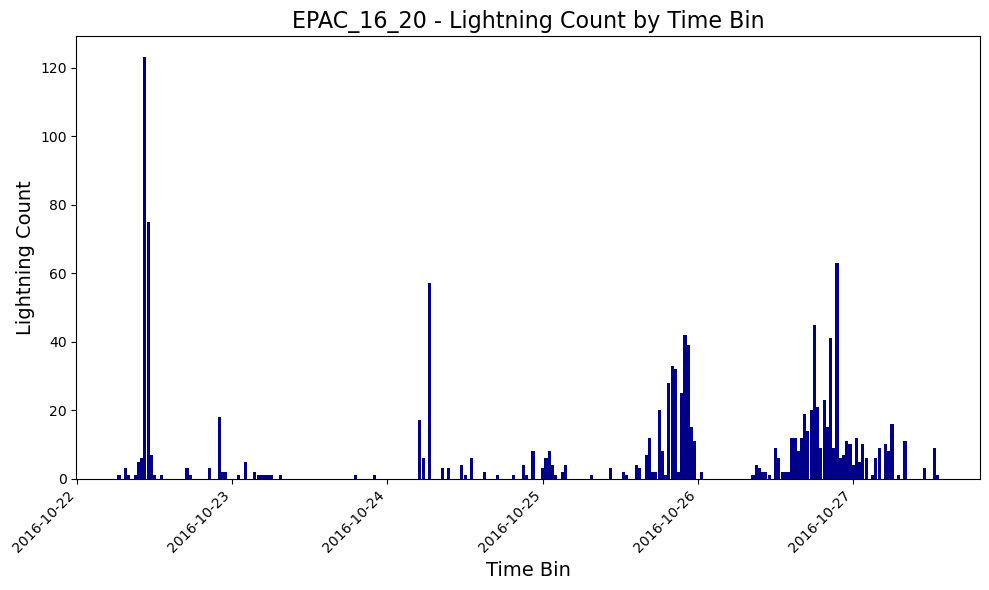

In [12]:
# Convert Polars DataFrame to pandas for plotting
epac_16_10 = innercore_data.filter(pl.col("storm_code") == "EPAC_16_20")
epac_16_10_pd = epac_16_10.to_pandas()

# Plot histogram (bar chart)
plt.figure(figsize=(10, 6))
plt.bar(epac_16_10_pd["time_bin"], epac_16_10_pd["lightning_count"], color="darkblue", width=0.02)

# Format plot
plt.title("EPAC_16_20 - Lightning Count by Time Bin", fontsize=16)
plt.xlabel("Time Bin", fontsize=14)
plt.ylabel("Lightning Count", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

#### EPAC Basin
Let's start with some exploratory analysis at the basin level.

In [33]:
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_data["storm_code"].unique().head()

storm_code
str
"""EPAC_16_17"""
"""EPAC_18_12"""
"""EPAC_13_17"""
"""EPAC_11_11"""
"""EPAC_18_10"""
"""EPAC_10_9"""
"""EPAC_11_10"""
"""EPAC_16_22"""
"""EPAC_13_13"""


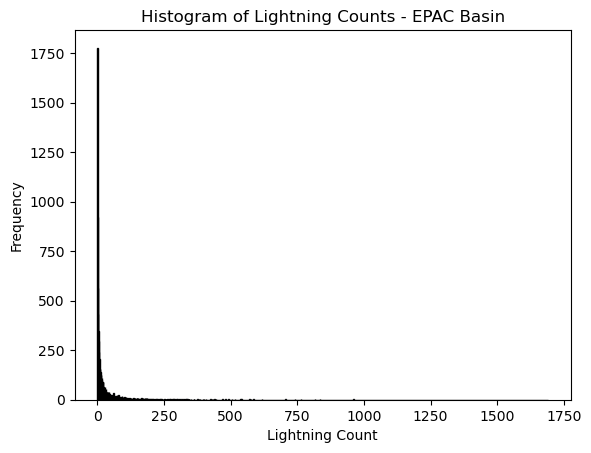

In [18]:
lightning_counts = epac_data["lightning_count"]
# Create histogram
plt.hist(lightning_counts, bins=range(1, max(lightning_counts) + 2), edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - EPAC Basin")
plt.show()

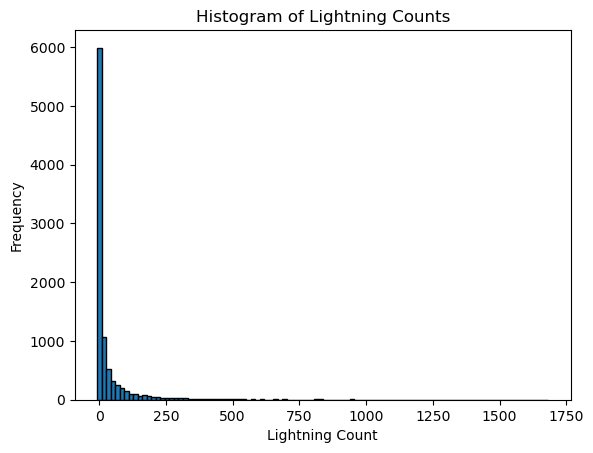

In [19]:
# Create histogram
plt.hist(lightning_counts, bins=100, edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts")
plt.show()

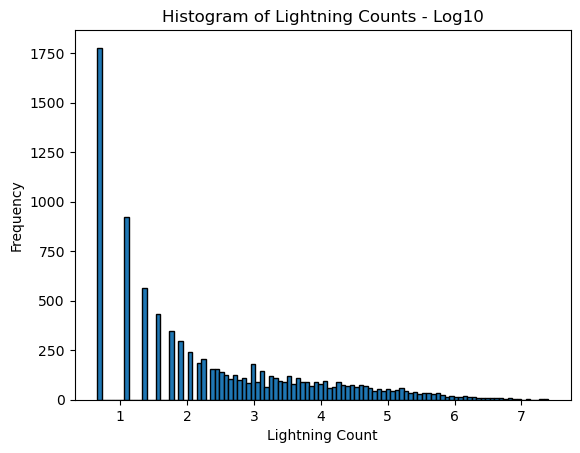

In [20]:
lightning_counts_log = epac_data["log_lightning_count"]

# Create histogram
plt.hist(lightning_counts_log, bins=100, edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - Log10")
plt.show()

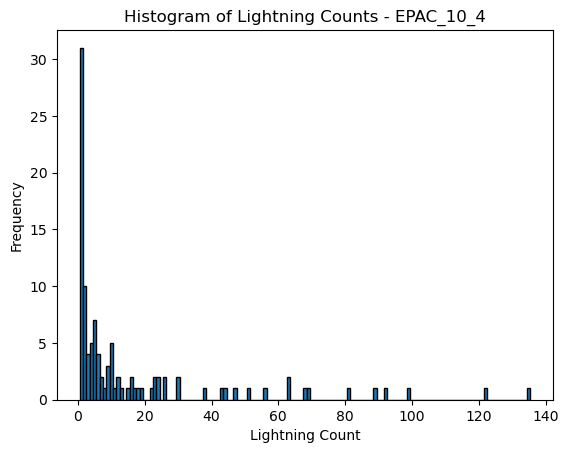

In [ ]:
# for one specific TC
epac_10_4 = epac_data.filter(pl.col("storm_code") == "EPAC_10_4")
lightning_counts = epac_10_4["lightning_count"]
# Create histogram
plt.hist(lightning_counts, bins=range(1, max(lightning_counts) + 2), edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - EPAC_10_4")
plt.show()

### EPAC Analysis Start Here 
1/27

Start at individual TC level then go to basin level threshold.

In [22]:
agg_result.head()

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold
0,ATL_10_1,0,0,4.158883,4.852030,1,0,4.054988,4.895449,6,0,3.562789,4.513729
1,ATL_10_11,14,11,2.720473,3.125938,8,4,3.642410,4.379726,6,0,4.000478,5.179731
2,ATL_10_12,0,0,8.030084,9.416378,0,0,6.632621,8.016123,0,0,5.438724,6.887542
3,ATL_10_13,0,0,5.940025,6.938554,7,0,5.337538,6.397270,10,0,5.151751,6.578021
4,ATL_10_14,5,1,4.158883,4.852030,4,0,4.276666,5.172546,5,0,4.159694,5.330809


In [23]:
processed.head()

,storm_code,time_bin,lightning_count,month,day,hour,minute,year,lat,lon,...,iqr_1,iqr_2,burst_mad_1,burst_mad_2,mad_1,mad_2,burst_lognormal_1,burst_lognormal_2,lognormal_2sigma,lognormal_3sigma
0,ATL_10_1,2010-06-21 07:00:00,1,6,21,7,0,2010,13.4,-66.5,...,4.054988,4.895449,False,False,4.158883,4.85203,False,False,3.562789,4.513729
1,ATL_10_1,2010-06-23 14:30:00,1,6,23,14,30,2010,15.9,-76.8,...,4.054988,4.895449,False,False,4.158883,4.85203,False,False,3.562789,4.513729
2,ATL_10_1,2010-06-23 15:00:00,3,6,23,15,0,2010,16.1,-77.7,...,4.054988,4.895449,False,False,4.158883,4.85203,False,False,3.562789,4.513729
3,ATL_10_1,2010-06-23 16:30:00,2,6,23,16,30,2010,16.1,-77.7,...,4.054988,4.895449,False,False,4.158883,4.85203,False,False,3.562789,4.513729
4,ATL_10_1,2010-06-23 22:30:00,4,6,23,22,30,2010,16.1,-77.7,...,4.054988,4.895449,False,False,4.158883,4.85203,False,False,3.562789,4.513729


need to figure out a way to evaluate these distributions/thresholds - look at proportion of bursts to timebins? it doesn't matter if a threshold is distributed way high if they're not catching a single burst

In [24]:
# basin-level summary of bursts
epac_storm_codes = epac_data["storm_code"].unique()
epac_agg_result = agg_result[agg_result["storm_code"].isin(epac_storm_codes)]

epac_agg_summary = epac_agg_result.drop(columns='storm_code').mean()
print(epac_agg_summary)

mad1_bursts        2.756098
mad2_bursts        1.597561
mad1_threshold     5.755425
mad2_threshold     6.693515
iqr1_bursts        2.402439
iqr2_bursts        0.597561
iqr1_threshold     5.168697
iqr2_threshold     6.185848
logn1_bursts       3.378049
logn2_bursts       0.097561
logn1_threshold    4.828719
logn2_threshold    6.124651
dtype: float64


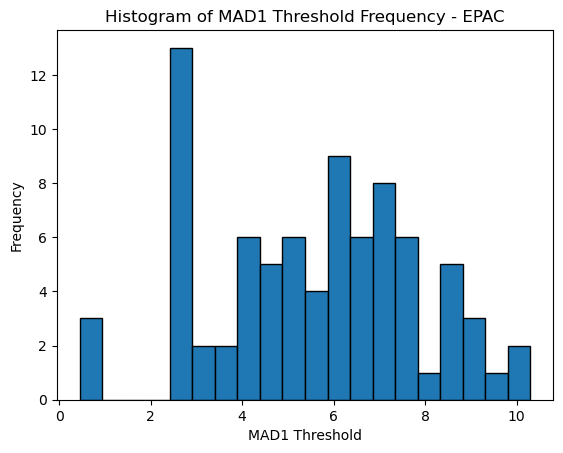

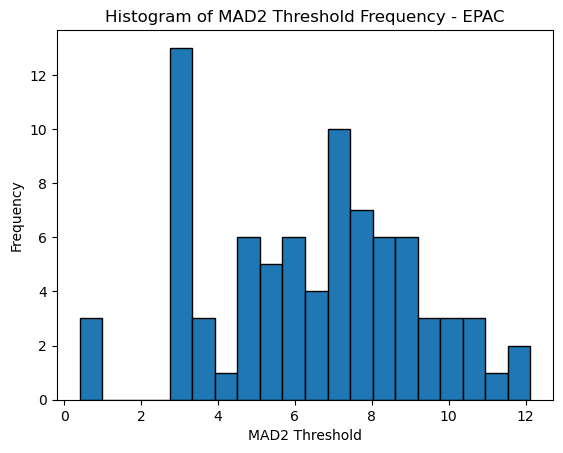

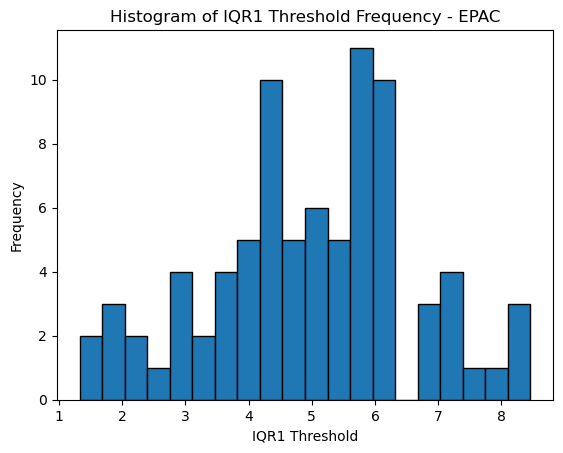

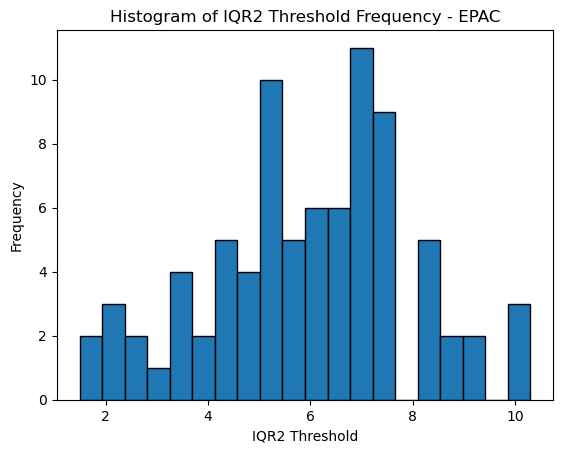

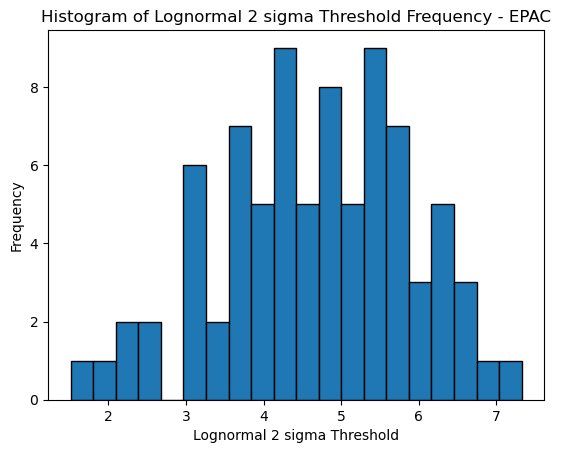

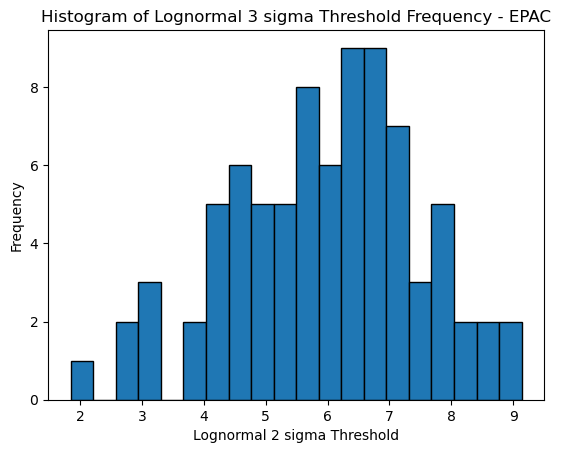

In [25]:
# basin-level distribution of thresholds

# distribution of mad1 thresholds
plt.hist(epac_agg_result["mad1_threshold"], bins=20, edgecolor="black", align="left")
plt.xlabel("MAD1 Threshold")
plt.ylabel("Frequency")
plt.title("Histogram of MAD1 Threshold Frequency - EPAC")
plt.show()

# distribution of mad2 thresholds
plt.hist(epac_agg_result["mad2_threshold"], bins=20, edgecolor="black", align="left")
plt.xlabel("MAD2 Threshold")
plt.ylabel("Frequency")
plt.title("Histogram of MAD2 Threshold Frequency - EPAC")
plt.show()

# distribution of iqr1 thresholds
plt.hist(epac_agg_result["iqr1_threshold"], bins=20, edgecolor="black", align="left")
plt.xlabel("IQR1 Threshold")
plt.ylabel("Frequency")
plt.title("Histogram of IQR1 Threshold Frequency - EPAC")
plt.show()

# distribution of iqr2 thresholds
plt.hist(epac_agg_result["iqr2_threshold"], bins=20, edgecolor="black", align="left")
plt.xlabel("IQR2 Threshold")
plt.ylabel("Frequency")
plt.title("Histogram of IQR2 Threshold Frequency - EPAC")
plt.show()

# distribution of lognormal1 thresholds
plt.hist(epac_agg_result["logn1_threshold"], bins=20, edgecolor="black", align="left")
plt.xlabel("Lognormal 2 sigma Threshold")
plt.ylabel("Frequency")
plt.title("Histogram of Lognormal 2 sigma Threshold Frequency - EPAC")
plt.show()

# distribution of lognormal2 thresholds
plt.hist(epac_agg_result["logn2_threshold"], bins=20, edgecolor="black", align="left")
plt.xlabel("Lognormal 2 sigma Threshold")
plt.ylabel("Frequency")
plt.title("Histogram of Lognormal 3 sigma Threshold Frequency - EPAC")
plt.show()

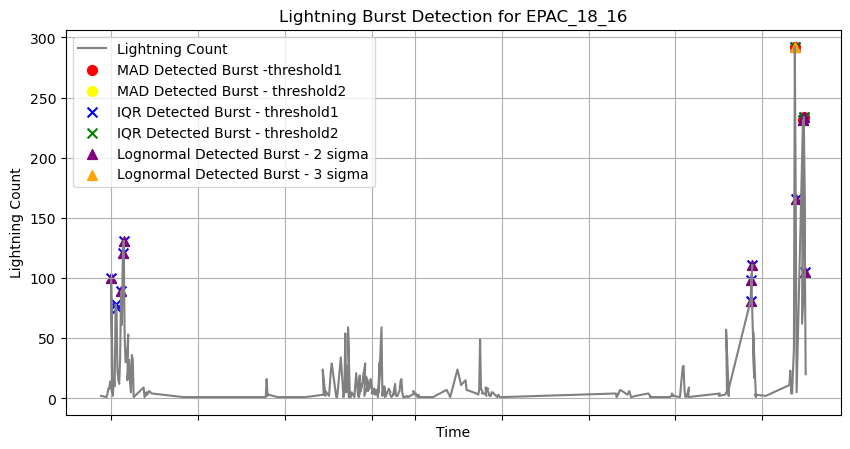

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold
154,EPAC_18_16,3,0,5.274601,6.190892,14,3,4.317488,5.122207,12,1,4.401107,5.608805


In [26]:
# Select a specific cyclone to visualize
cyclone_id = 'EPAC_18_16'
df_cyclone = processed[processed['storm_code'] == cyclone_id]

plt.figure(figsize=(10, 5))
plt.plot(df_cyclone['time_bin'], df_cyclone['lightning_count'], label='Lightning Count', color='gray')

# Mark bursts detected by MAD
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
            color='red', label='MAD Detected Burst -threshold1', s=50, marker='o')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
            color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
            color='green', label='IQR Detected Burst - threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

plt.xlabel('Time')
plt.ylabel('Lightning Count')
plt.title(f'Lightning Burst Detection for {cyclone_id}')
plt.legend()
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

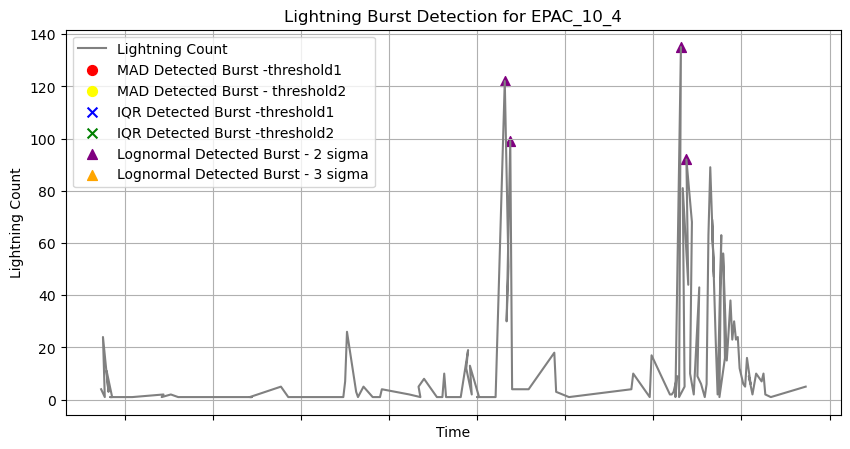

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold
91,EPAC_10_4,0,0,6.186209,7.284821,0,0,5.141664,6.253793,4,0,4.530418,5.785126


In [27]:
# Select a specific cyclone to visualize
cyclone_id = 'EPAC_10_4'
df_cyclone = processed[processed['storm_code'] == cyclone_id]

plt.figure(figsize=(10, 5))
plt.plot(df_cyclone['time_bin'], df_cyclone['lightning_count'], label='Lightning Count', color='gray')

# Mark bursts detected by MAD
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
            color='red', label='MAD Detected Burst -threshold1', s=50, marker='o')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
            color='blue', label='IQR Detected Burst -threshold1', s=50, marker='x')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
            color='green', label='IQR Detected Burst -threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

plt.xlabel('Time')
plt.ylabel('Lightning Count')
plt.title(f'Lightning Burst Detection for {cyclone_id}')
plt.legend()
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

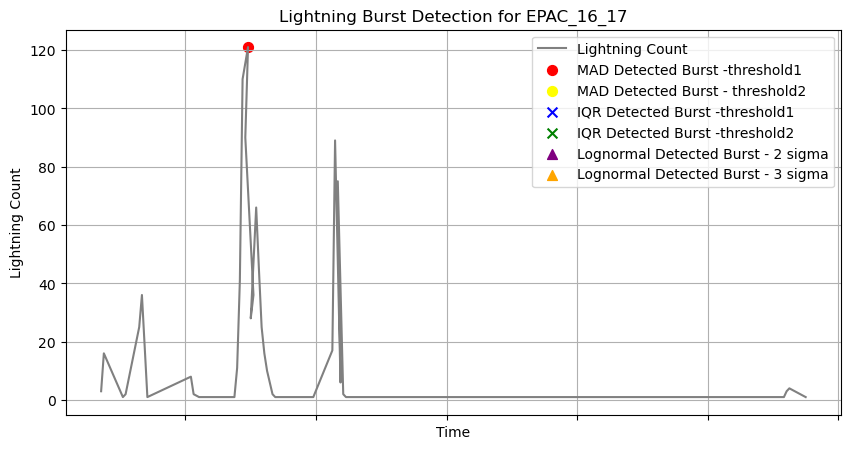

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold
139,EPAC_16_17,1,0,4.716742,5.521461,0,0,5.986845,7.310269,0,0,5.012689,6.465609


In [28]:
# Select a specific cyclone to visualize
cyclone_id = 'EPAC_16_17'
df_cyclone = processed[processed['storm_code'] == cyclone_id]

plt.figure(figsize=(10, 5))
plt.plot(df_cyclone['time_bin'], df_cyclone['lightning_count'], label='Lightning Count', color='gray')

# Mark bursts detected by MAD
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
            color='red', label='MAD Detected Burst -threshold1', s=50, marker='o')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
            color='blue', label='IQR Detected Burst -threshold1', s=50, marker='x')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
            color='green', label='IQR Detected Burst -threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

plt.xlabel('Time')
plt.ylabel('Lightning Count')
plt.title(f'Lightning Burst Detection for {cyclone_id}')
plt.legend()
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]